In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# Problem definition

In [6]:
NUMBERS = [2, 3, 5, 7, 10, 12, 15, 20, 23, 25, 30, 35, 40, 50, 60]
OPERATIONS = ["+", "-", "*", "/"]
TARGET = 567

def f(operation):
  value = abs(operation.evaluate() - TARGET)
  # Some unvalid expressions can lead to nan (when inf * 0 happens). Give them f = inf.
  if np.isnan(value): value = float('inf')

  # Apply a penalization if the operation has less than 8 numbers
  pen_term = 8 - len(operation.numbers)
  if pen_term > 0:
    value += 50 * pen_term

  return value

def check_valid(operation):
  return len(operation.numbers) >= 8

def f2(operation):
  value = abs(operation.evaluate() - TARGET)
  # Some unvalid expressions can lead to nan (when inf * 0 happens). Give them f = inf.
  if np.isnan(value): value = float('inf')
  
  # Apply a penalization if the operation has less than 8 numbers
  pen_term = 8 - len(operation.numbers)
  if pen_term > 0:
    value += 50 * pen_term

  # Apply a second penalization if the operation repeats numbers
  pen_term2 = (np.unique(operation.numbers, return_counts=True)[1] - 1).sum() # Number of repetitions
  value += 100 * pen_term2
  return value

def check_valid2(operation):
  return len(operation.numbers) >= 8 and np.all(np.unique(operation.numbers, return_counts=True)[1] == 1)

# Solution space

In [7]:
class Operation:
    def __init__(self, numbers, operations, order):
        self.numbers = numbers
        self.operations = operations
        self.order = order

    def __str__(self):
        return f"{self.numbers} {self.operations} {self.order}"

    def __repr__(self):
        return self.__str__()

    def evaluate(self):
      # Copy the numbers list to avoid modifying the original
      num_list = self.numbers[:]
      op_list = self.operations[:]
      order_list = self.order[:]

      for i in range(len(order_list)):

          op_index = order_list[i]

          num1 = num_list[op_index]
          num2 = num_list[op_index + 1]
          operation = op_list[op_index]

          if operation == '+':
              result = num1 + num2
          elif operation == '-':
              result = num1 - num2
          elif operation == '*':
              result = num1 * num2
          elif operation == '/':
              result = num1 / num2 if num2 != 0 else float('inf')
          
          # Replace the numbers in the list with the result of the operation
          num_list[op_index] = result
          num_list.pop(op_index + 1)  # Remove the second number

          # Remove the operation from the list
          op_list.pop(op_index)

          # Decrement all indices that are greater than op_index
          order_list = [i - 1 if i > op_index else i for i in order_list]

      # The result of the final evaluation is the only element left in num_list
      return num_list[0]

    def copy(self):
        return Operation(self.numbers.copy(), self.operations.copy(), self.order.copy())


In [8]:
example = Operation([4, 5, 6, 7], ['+', '-', '/'], [2,0,1])
print(example)
print(example.evaluate())

[4, 5, 6, 7] ['+', '-', '/'] [2, 0, 1]
8.142857142857142


In [9]:
ejemplo = Operation([35, 30, 25, 12, 20, 50, 3, 2, 7, 10, 23, 5], ['+', '*', '*', '/', '+', '+', '-', '+', '+', '+', '+'], [1, 3, 0, 6, 2, 8, 4, 5, 9, 7, 10])
print(ejemplo)
print(ejemplo.evaluate())

[35, 30, 25, 12, 20, 50, 3, 2, 7, 10, 23, 5] ['+', '*', '*', '/', '+', '+', '-', '+', '+', '+', '+'] [1, 3, 0, 6, 2, 8, 4, 5, 9, 7, 10]
567.0


# Mutations

Next, we define some functions that generate neighbouring solutions to the one provided, by seven different mechanisms.

In [10]:
from re import L
import random
def swap_random(l):
    i = random.randint(0, len(l) - 1)
    j = random.randint(0, len(l) - 1)
    l[i], l[j] = l[j], l[i]
    return l

# Create a new operation that has a different order of operations
def swap_order(operation):
    new_op = operation.copy()
    new_op.order = swap_random(new_op.order)
    return new_op

def swap_numbers(operation):
    new_op = operation.copy()
    new_op.numbers = swap_random(new_op.numbers)
    return new_op

def swap_operations(operation):
    new_op = operation.copy()
    new_op.operations = swap_random(new_op.operations)
    return new_op

def change_operation(operation):
    new_op = operation.copy()
    new_op.operations[random.randint(0, len(new_op.operations) - 1)] = random.choice(OPERATIONS)
    return new_op

def change_number(operation):
    new_op = operation.copy()
    new_op.numbers[random.randint(0, len(new_op.numbers) - 1)] = random.choice(NUMBERS)
    return new_op

# We will only add and remove operations from the end of the list, since later they can swap.
# Maybe we can try later if allowing inserts and pops in random places improves.
def add_operation(operation):
    new_op = operation.copy()
    new_op.operations.append(random.choice(OPERATIONS)) # Add a new operation at the end
    new_op.order.append(len(new_op.operations) - 1) # Make that operation the lowest priority
    new_op.numbers.append(random.choice(NUMBERS)) # Add a new number at the end to operate with
    return new_op

def remove_operation(operation):
    new_op = operation.copy()
    new_op.order.remove(len(new_op.operations) - 1) # Remove the last operation from the order list
    new_op.operations = new_op.operations[:-1] # Remove the last operation
    new_op.numbers = new_op.numbers[:-1] # Remove the last number
    return new_op

Some of the previous functions (`change_number` and `add_operation`) may generate solutions with repeated numbers. Since we also want to solve a version of the problem with no repeated numbers as a hard restriction (i.e. no intermediate solutions with repeated numbers allowed), we will program counterparts that prevent repeated numbers:

In [11]:
def change_number_nrpt(operation):
    if len(operation.numbers) >= len(NUMBERS):
        return operation
    new_op = operation.copy()
    try:
      new_op.numbers[random.randint(0, len(new_op.numbers) - 1)] = random.choice(list(set(NUMBERS)-set(new_op.numbers)))
    except:
      print(operation)
      raise
    return new_op

def add_operation_nrpt(operation):
    if len(operation.numbers) >= len(NUMBERS):
        return operation
    new_op = operation.copy()
    new_op.operations.append(random.choice(OPERATIONS)) # Add a new operation at the end
    new_op.order.append(len(new_op.operations) - 1) # Make that operation the lowest priority
    new_op.numbers.append(random.choice(list(set(NUMBERS)-set(new_op.numbers)))) # Add a new number at the end to operate with
    return new_op

We aggregate these functions into two neighbour generator functions, that run one of the above at random with uniform probability:

In [12]:
# Generate a random neighbour solution
def get_neighbour(operation):
  calls = [swap_order, swap_numbers, swap_operations, change_operation, change_number, add_operation, remove_operation]
  if len(operation.operations) == 0:
    calls = [add_operation] # If the operation is just a number, prevent from doing any changes that require operations.
  return random.choice(calls)(operation)

# Generate a random neighbour solution without adding repeated numbers.
def get_neighbour_nrpt(operation):
  calls = [swap_order, swap_numbers, swap_operations, change_operation, change_number_nrpt, add_operation_nrpt, remove_operation]
  if len(operation.operations) == 0:
    calls = [add_operation_nrpt] # If the operation is just a number, prevent from doing any changes that require operations.
  return random.choice(calls)(operation)

# Simulated annealing

In [13]:
import math

"""
Runs the simulated annealing metaheuristic.
Args:
  - x0: initial solution.
  - f: function to be minimized.
  - check_valid: solution -> bool function. Checks that the solution satisfies all restrictions of the problem.
  - gen_neihbour: function that defines the solution environment. Generates a neighbour solution from another solution.
  - T0, alpha: parameters.
  - max_iterations, tol: stop criteria.
"""
def simulated_annealing(x0, f, check_valid, gen_neighbour, T0=1000, alpha=0.99, max_iterations=1000, tol=0.01, log=True):
  # Log info
  X = [x0]
  V = [x0.evaluate()]
  F = [f(x0)]
  Tv = [T0]

  # Run SA
  x = x0
  T = T0
  best_x, best_f = x, f(x)

  stop_counter = 0
  for i in range(max_iterations):
    x_new = gen_neighbour(x)
    f_new = f(x_new)
    delta_f = f_new - f(x)

    stop_counter += 1
    if delta_f < 0:
      x = x_new
      if f_new < best_f and check_valid(x_new):
        best_x, best_f = x, f_new
        stop_counter = 0
    else:
      u = random.random()
      if u < math.exp(-delta_f / T):
        x = x_new
        if f_new < best_f and check_valid(x_new):
          best_x, best_f = x, f_new
          stop_counter = 0

    T = T * alpha

    # Print Current info
    if log:
      print(f"Iter: {i} | f: {f(x):.3f} | best_f: {best_f:.3f}")

    # Log
    X.append(x)
    V.append(x.evaluate())
    F.append(f(x))
    Tv.append(T)

    # Stop criteria
    if best_f < tol:
        if log:
          print(f"Solución encontrada")
        break

  return best_x, best_f, X, V, F, Tv

# Genetic algorithm

Define some specific functions for the genetic algorithm:

In [14]:
def generate_population(size) -> list[Operation]:
    population = []
    for _ in range(size):
        n_initial = random.randint(8, len(NUMBERS)) # Number of numbers in the initial solution
        initial_op = Operation(
            numbers = random.sample(NUMBERS, k=n_initial),
            operations = random.choices(OPERATIONS, k=n_initial-1),
            order = random.sample(list(range(n_initial-1)), k=n_initial-1)
        )
        population.append(initial_op)
    return population

# Creates a new operation that is the sum of the first half of op1 and the second half of op2
def crossover(op1, op2):
    new_numbers = op1.numbers[:math.ceil(len(op1.numbers)/2)] + op2.numbers[len(op2.numbers)//2:]
    op1cut = len(op1.operations)//2
    op2cut = math.ceil(len(op2.operations)/2)
    new_operations = op1.operations[:op1cut] + ['+'] + op2.operations[op2cut:]
    new_order = [i for i in op1.order if i < op1cut] + [i - op2cut + op1cut + 1 for i in op2.order if i >= op2cut] + [op1cut]
    return Operation(new_numbers, new_operations, new_order)

# Crossover that avoids generating solutions with repeated numbers.
# 1. Creates a new solution as the sum of the halfs of op1 and op2
# 2. Shrinks the operation and replaces numbers as necessary to avoid repeated numbers.
def crossover_nrpt(op1, op2):
    new_numbers = op1.numbers[:math.ceil(len(op1.numbers)/2)] + op2.numbers[len(op2.numbers)//2:]
    op1cut = len(op1.operations)//2
    op2cut = math.ceil(len(op2.operations)/2)
    new_operations = op1.operations[:op1cut] + ['+'] + op2.operations[op2cut:]
    new_order = [i for i in op1.order if i < op1cut] + [i - op2cut + op1cut + 1 for i in op2.order if i >= op2cut] + [op1cut]
    
    # Ensure no number repetitions
    # If the operation is larger than NUMBERS, shrink it down so that no numbers have to be repeated.
    extra = len(new_numbers) - len(NUMBERS)
    if extra > 0:
        new_numbers = new_numbers[:len(new_numbers)-extra]
        new_operations = new_operations[:len(new_operations)-extra]
        new_order = [i for i in new_order if i < len(new_operations)]
  
    # Replace any repeated numbers with a number not in the operation.
    new_numbers = np.array(new_numbers)
    unique, counts = np.unique(new_numbers, return_counts=True)
    
    # Find duplicates and unused numbers
    duplicates = unique[counts > 1]
    if len(duplicates) > 0:
        unused = np.setdiff1d(NUMBERS, unique, assume_unique=True)
        
        # Replace duplicates with unused numbers
        for dup in duplicates:
            indices = np.where(new_numbers == dup)[0][1:]  # All occurrences except the first
            new_numbers[indices] = unused[:len(indices)] # Replace from unused numbers
            unused = unused[len(indices):]  # Remove used replacements
    
    return Operation(new_numbers.tolist(), new_operations, new_order)


def roulette_wheel_selection(population, f):
    # Calculate fitness for each individual (inverse of the function trying to minimize)
    fitnesses = np.array([1/f(i) for i in population])
    total_fitness = sum(fitnesses)
    prob = fitnesses / total_fitness

    # Select an individual with probability proportional to their fitness.
    selected = np.random.choice(population, p=prob)
    return selected

"""
Runs the genetic algorithm.
Args:
    - f: function to be minimized.
    - check_valid: solution -> bool function. Checks that the solution satisfies all restrictions of the problem. 
    - crossover: a function that creates a child solution from two parent solutions.
    - mutate: a function that takes a solution and returns a mutated version of it.
    - population_size, mutation_rate: parameters.
    - max_generations, tol: stop criteria.
"""

def genetic_algorithm(f, check_valid, crossover, mutate, population_size=100,  mutation_rate=0.01, max_generations=1000, tol=0.01, log=True):
    population = generate_population(population_size)
    fitnesses = [f(ind) for ind in population]
    best_global_ind = population[np.argmin(fitnesses)]
    best_global_fitness = fitnesses[np.argmin(fitnesses)]

    # Log info
    X = [best_global_ind]
    V = [best_global_ind.evaluate()]
    F = [best_global_fitness]

    stop_counter = 0
    for gen in range(max_generations):
        fitnesses = [f(ind) for ind in population]
        best_idx = np.argmin(fitnesses)
        best_ind = population[best_idx]
        best_fitness =  fitnesses[best_idx]

        stop_counter += 1
        if best_global_fitness > best_fitness and check_valid(best_ind):
            best_global_ind = best_ind
            best_global_fitness = best_fitness
            stop_counter = 0

        if log:
            print(f"Generación: {gen + 1} | Mejor fitness: {best_fitness:.2f} (Global: {best_global_fitness:.2f}) | Resultado: {best_ind.evaluate():.2f} (Global: {best_global_ind.evaluate():.2f})")
        
        # Log info
        X.append(best_global_ind)
        V.append(best_global_ind.evaluate())
        F.append(best_global_fitness)

        # Stop criteria
        if best_global_fitness < tol or stop_counter > 20:
            if log:
                print(f"Solución encontrada")
            break

        new_population = []

        while len(new_population) < population_size:
            parent1 = roulette_wheel_selection(population, f)
            parent2 = roulette_wheel_selection(population, f)

            child = crossover(parent1, parent2)
            #child = parent1.copy()
            if random.random() < mutation_rate:
                child = mutate(child)

            new_population.append(child)

        population = new_population
    return best_global_ind, best_global_fitness, X, V, F

# Random search

As a comparison with the metaheuristics, we implement a classic method: random search. The algorithm consists on sampling a random neighbouring point and moving to it if the function there has a lower value.

```pseudo
Initialize x at random.
Until stop criteria:
    Sample x', neighbour of x
    if f(x') < f(x):
        x = x'
Return x'
```

In [15]:
"""
Runs random search.
Args:
  - x0: initial solution.
  - f: function to be minimized.
  - check_valid: solution -> bool function. Checks that the solution satisfies all restrictions of the problem.
  - gen_neihbour: function that defines the solution environment. Generates a neighbour solution from another solution.
  - max_iterations, tol: stop criteria.
"""

def random_search(x0, f, check_valid, gen_neighbour, max_iterations=1000, tol=0.01, log=True):
  # Log info
  X = [x0]
  V = [x0.evaluate()]
  F = [f(x0)]

  x = x0
  best_x, best_f = x, f(x)

  #stop_counter = 0

  for i in range(max_iterations):
    neighbour = gen_neighbour(x)
    neighbour_f = f(neighbour)

    #stop_counter += 1
    if neighbour_f < f(x):
      x = neighbour

      if neighbour_f < best_f and check_valid(neighbour):
          best_x, best_f = neighbour, neighbour_f
          #stop_counter = 0

    # Print Current info
    if log:
      print(f"Iter: {i} | f: {f(x):.3f} | best_f: {best_f:.3f}")

    # Log
    X.append(x)
    V.append(x.evaluate())
    F.append(f(x))

    # Stop criteria
    if best_f < tol:
        if log:
          print(f"Solución encontrada")
        break

  return best_x, best_f, X, V, F

# Testing the algorithms

In this section we run the algorithms to solve the problem in three different ways:

P1: Allowing repetition of numbers in the operations:
- Fitness function: `f`
- Check valid function: `check_valid`
- Neighbour/mutation function: `get_neighbour`
- Crossover function: `crossover`

P2: Adding non-repetition of numbers as a soft restriction (penalization in the fitness function).
- Fitness function: `f2`
- Check valid function: `check_valid2`
- Neighbour/mutation function: `get_neighbour`
- Crossover function: `crossover`

P3: Adding non-repetition of numbers as a hard restriction (intermediate non-valid solutions not allowed)
- Fitness function: `f`
- Check valid function: `check_valid2`
- Neighbour/mutation function: `get_neighbour_nrpt`
- Crossover function: `crossover_nrpt`

Generate an initial solution for simulated annealing and random search.

In [12]:
n_initial = 8 # Number of numbers in the initial solution
initial_op = Operation(
    numbers = random.sample(NUMBERS, k=n_initial),
    operations = random.choices(OPERATIONS, k=n_initial-1),
    order = random.sample(list(range(n_initial-1)), k=n_initial-1)
)

max_iter = 1000
tol = 0.01

## P1

Simulated Annealing

In [13]:
P1sa_x, P1sa_f, P1sa_X, P1sa_V, P1sa_F, P1sa_Tv = simulated_annealing(initial_op, f, check_valid, get_neighbour, T0=500, alpha=0.90, max_iterations=max_iter, tol=tol)

Iter: 0 | f: 1197.729 | best_f: 1197.729
Iter: 1 | f: 1072.398 | best_f: 1072.398
Iter: 2 | f: 1072.478 | best_f: 1072.398
Iter: 3 | f: 1072.478 | best_f: 1072.398
Iter: 4 | f: 1072.478 | best_f: 1072.398
Iter: 5 | f: 1073.246 | best_f: 1072.398
Iter: 6 | f: 579.400 | best_f: 579.400
Iter: 7 | f: 579.400 | best_f: 579.400
Iter: 8 | f: 579.160 | best_f: 579.160
Iter: 9 | f: 573.845 | best_f: 573.845
Iter: 10 | f: 520.961 | best_f: 520.961
Iter: 11 | f: 520.961 | best_f: 520.961
Iter: 12 | f: 562.674 | best_f: 520.961
Iter: 13 | f: 577.699 | best_f: 520.961
Iter: 14 | f: 582.099 | best_f: 520.961
Iter: 15 | f: 582.099 | best_f: 520.961
Iter: 16 | f: 582.099 | best_f: 520.961
Iter: 17 | f: 567.446 | best_f: 520.961
Iter: 18 | f: 567.446 | best_f: 520.961
Iter: 19 | f: 567.441 | best_f: 520.961
Iter: 20 | f: 593.487 | best_f: 520.961
Iter: 21 | f: 593.487 | best_f: 520.961
Iter: 22 | f: 593.487 | best_f: 520.961
Iter: 23 | f: 580.087 | best_f: 520.961
Iter: 24 | f: 580.087 | best_f: 520.96

Genetic Algorithm

In [14]:
P1ga_x, P1ga_f, P1ga_X, P1ga_V, P1ga_F = genetic_algorithm(f, check_valid, crossover, mutate=get_neighbour, population_size=100, max_generations=max_iter, mutation_rate=0.1, tol=tol)

Generación: 1 | Mejor fitness: 10.00 (Global: 10.00) | Resultado: 577.00 (Global: 577.00)
Generación: 2 | Mejor fitness: 12.00 (Global: 10.00) | Resultado: 579.00 (Global: 577.00)
Generación: 3 | Mejor fitness: 2.97 (Global: 2.97) | Resultado: 564.03 (Global: 564.03)
Generación: 4 | Mejor fitness: 3.00 (Global: 2.97) | Resultado: 564.00 (Global: 564.03)
Generación: 5 | Mejor fitness: 7.56 (Global: 2.97) | Resultado: 574.56 (Global: 564.03)
Generación: 6 | Mejor fitness: 7.56 (Global: 2.97) | Resultado: 574.56 (Global: 564.03)
Generación: 7 | Mejor fitness: 0.56 (Global: 0.56) | Resultado: 567.56 (Global: 567.56)
Generación: 8 | Mejor fitness: 0.56 (Global: 0.56) | Resultado: 567.56 (Global: 567.56)
Generación: 9 | Mejor fitness: 0.56 (Global: 0.56) | Resultado: 567.56 (Global: 567.56)
Generación: 10 | Mejor fitness: 3.56 (Global: 0.56) | Resultado: 570.56 (Global: 567.56)
Generación: 11 | Mejor fitness: 3.56 (Global: 0.56) | Resultado: 570.56 (Global: 567.56)
Generación: 12 | Mejor fit

Random Search

In [15]:
P1rs_x, P1rs_f, P1rs_X, P1rs_V, P1rs_F = random_search(initial_op, f, check_valid, get_neighbour, max_iterations=max_iter, tol=tol)

Iter: 0 | f: 25796.154 | best_f: 25796.154
Iter: 1 | f: 4808.154 | best_f: 4808.154
Iter: 2 | f: 4808.154 | best_f: 4808.154
Iter: 3 | f: 2362.000 | best_f: 2362.000
Iter: 4 | f: 1825.000 | best_f: 1825.000
Iter: 5 | f: 383.333 | best_f: 383.333
Iter: 6 | f: 133.333 | best_f: 133.333
Iter: 7 | f: 133.333 | best_f: 133.333
Iter: 8 | f: 133.333 | best_f: 133.333
Iter: 9 | f: 133.333 | best_f: 133.333
Iter: 10 | f: 96.000 | best_f: 96.000
Iter: 11 | f: 96.000 | best_f: 96.000
Iter: 12 | f: 96.000 | best_f: 96.000
Iter: 13 | f: 96.000 | best_f: 96.000
Iter: 14 | f: 96.000 | best_f: 96.000
Iter: 15 | f: 96.000 | best_f: 96.000
Iter: 16 | f: 96.000 | best_f: 96.000
Iter: 17 | f: 96.000 | best_f: 96.000
Iter: 18 | f: 96.000 | best_f: 96.000
Iter: 19 | f: 96.000 | best_f: 96.000
Iter: 20 | f: 96.000 | best_f: 96.000
Iter: 21 | f: 96.000 | best_f: 96.000
Iter: 22 | f: 96.000 | best_f: 96.000
Iter: 23 | f: 96.000 | best_f: 96.000
Iter: 24 | f: 42.000 | best_f: 42.000
Iter: 25 | f: 32.058 | best_

Show results:

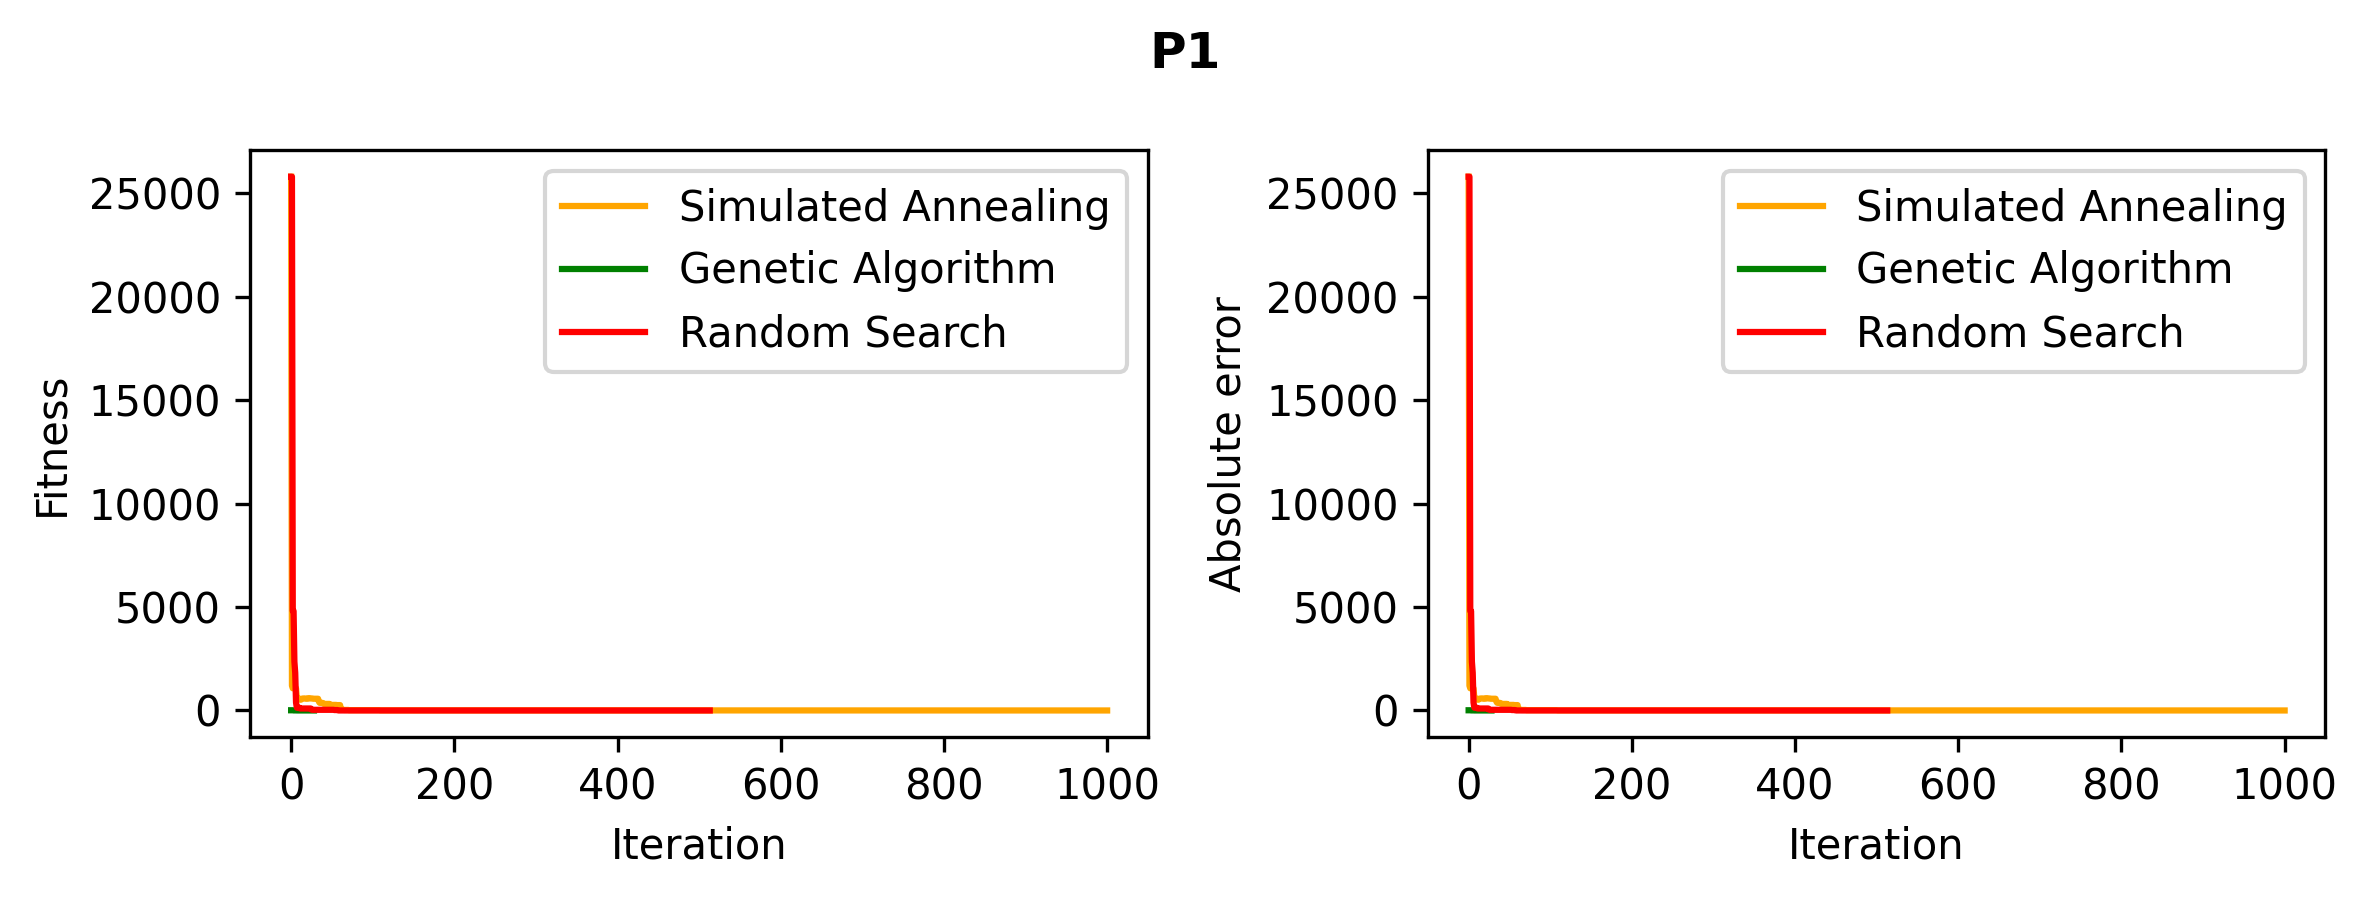

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax[0].plot(P1sa_F, color='orange', label='Simulated Annealing')
ax[0].plot(P1ga_F, color='green', label='Genetic Algorithm')
ax[0].plot(P1rs_F, color='red', label='Random Search')

ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')

ax[1].plot(np.abs(np.array(P1sa_V) - TARGET), color='orange', label='Simulated Annealing')
ax[1].plot(np.abs(np.array(P1ga_V) - TARGET), color='green', label='Genetic Algorithm')
ax[1].plot(np.abs(np.array(P1rs_V) - TARGET), color='red', label='Random Search')

ax[1].set_ylabel('Absolute error')
ax[1].set_xlabel('Iteration')

for a in ax:
    a.legend()

plt.suptitle("P1", fontweight='bold')
plt.tight_layout()
plt.show()

## P2

In [17]:
P2sa_x, P2sa_f, P2sa_X, P2sa_V, P2sa_F, P2sa_Tv = simulated_annealing(initial_op, f2, check_valid2, get_neighbour, T0=1000, alpha=0.90, max_iterations=max_iter, tol=tol, log=False)
P2ga_x, P2ga_f, P2ga_X, P2ga_V, P2ga_F = genetic_algorithm(f2, check_valid2, crossover, mutate=get_neighbour, population_size=100, max_generations=max_iter, mutation_rate=0.1, tol=tol, log=False)
P2rs_x, P2rs_f, P2rs_X, P2rs_V, P2rs_F = random_search(initial_op, f2, check_valid2, get_neighbour, max_iterations=max_iter, tol=tol, log=False)

Show results:

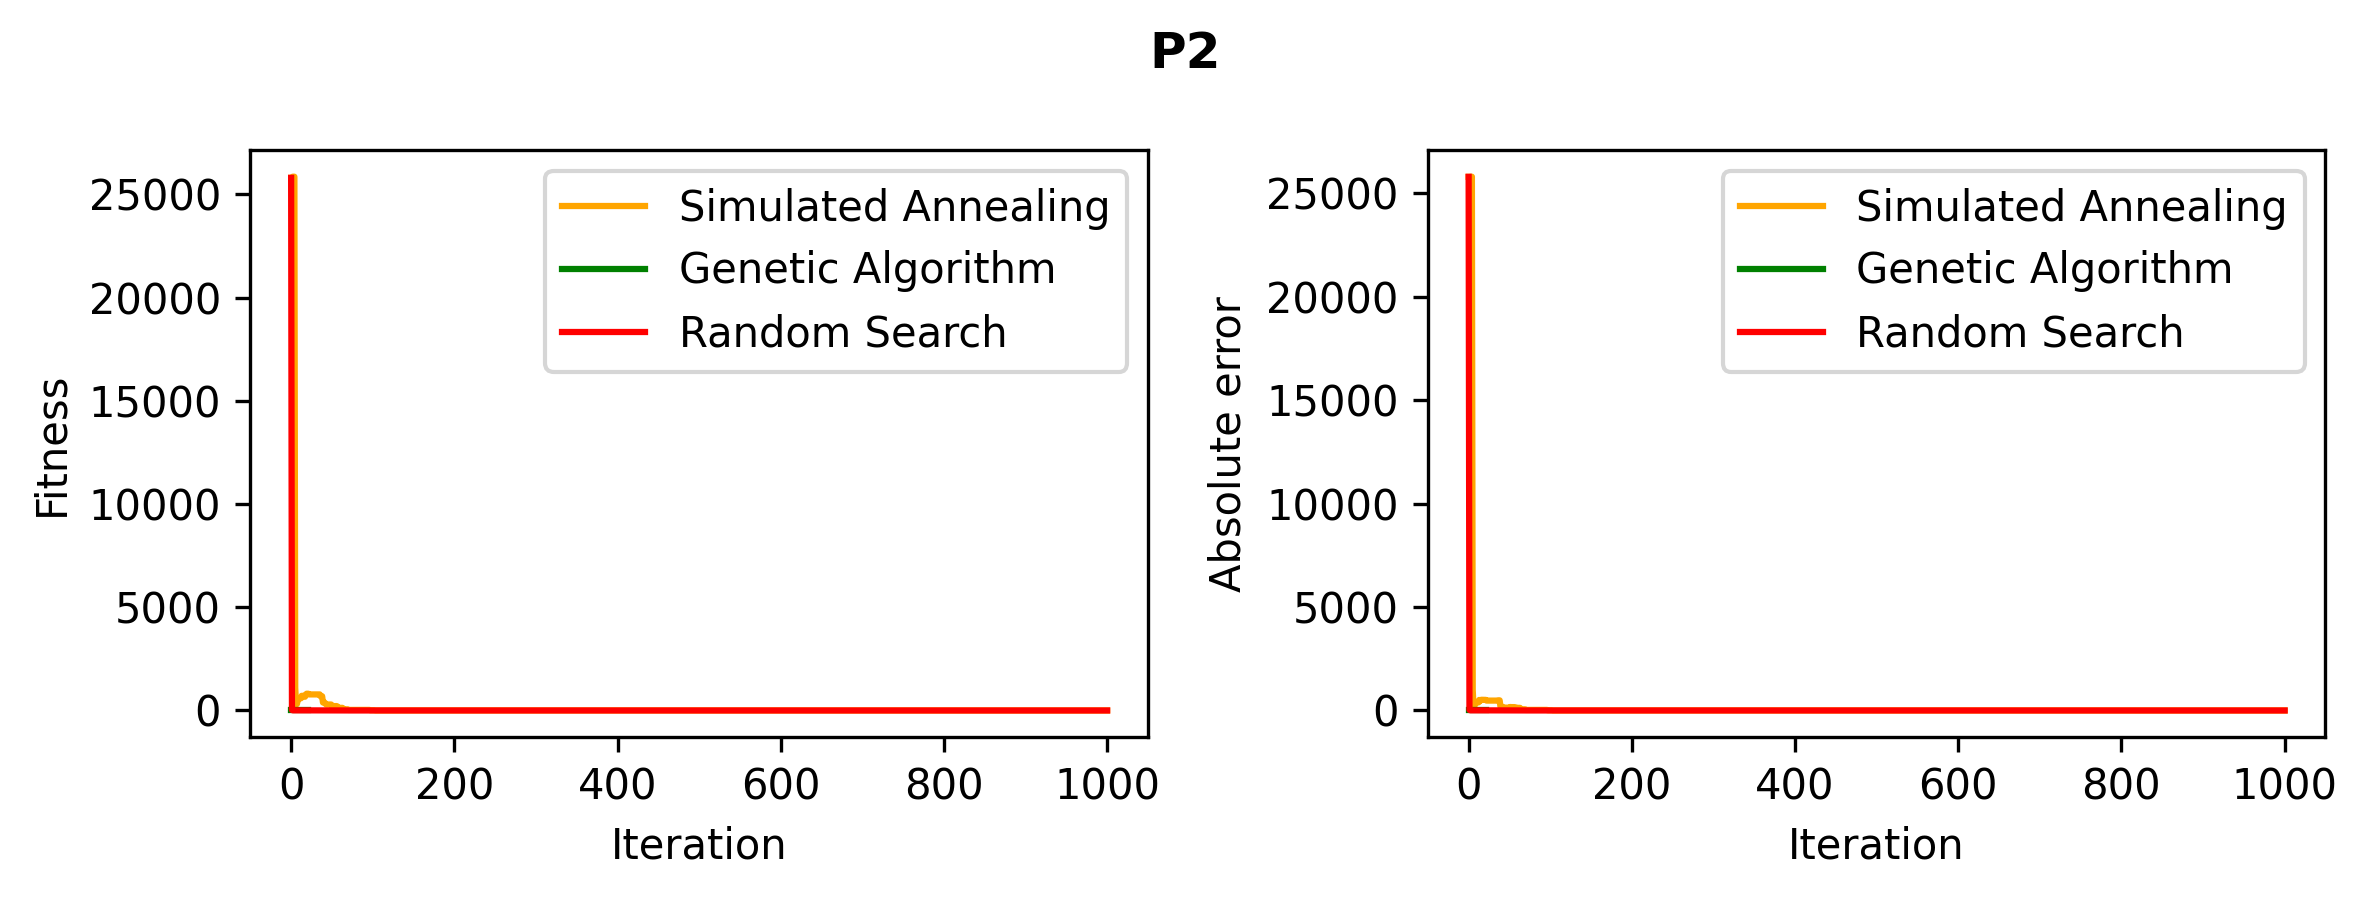

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax[0].plot(P2sa_F, color='orange', label='Simulated Annealing')
ax[0].plot(P2ga_F, color='green', label='Genetic Algorithm')
ax[0].plot(P2rs_F, color='red', label='Random Search')

ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')

ax[1].plot(np.abs(np.array(P2sa_V) - TARGET), color='orange', label='Simulated Annealing')
ax[1].plot(np.abs(np.array(P2ga_V) - TARGET), color='green', label='Genetic Algorithm')
ax[1].plot(np.abs(np.array(P2rs_V) - TARGET), color='red', label='Random Search')

ax[1].set_ylabel('Absolute error')
ax[1].set_xlabel('Iteration')

for a in ax:
    a.legend()
    
plt.suptitle('P2', fontweight='bold')
plt.tight_layout()
plt.show()

# P3

In [25]:
P3sa_x, P3sa_f, P3sa_X, P3sa_V, P3sa_F, P3sa_Tv = simulated_annealing(initial_op, f, check_valid2, get_neighbour_nrpt, T0=500, alpha=0.90, max_iterations=max_iter, tol=tol, log=False)
P3ga_x, P3ga_f, P3ga_X, P3ga_V, P3ga_F = genetic_algorithm(f, check_valid2, crossover_nrpt, mutate=get_neighbour_nrpt, population_size=100, max_generations=max_iter, mutation_rate=0.1, tol=tol, log=False)
P3rs_x, P3rs_f, P3rs_X, P3rs_V, P3rs_F = random_search(initial_op, f, check_valid2, get_neighbour_nrpt, max_iterations=1000, tol=0.01, log=False)

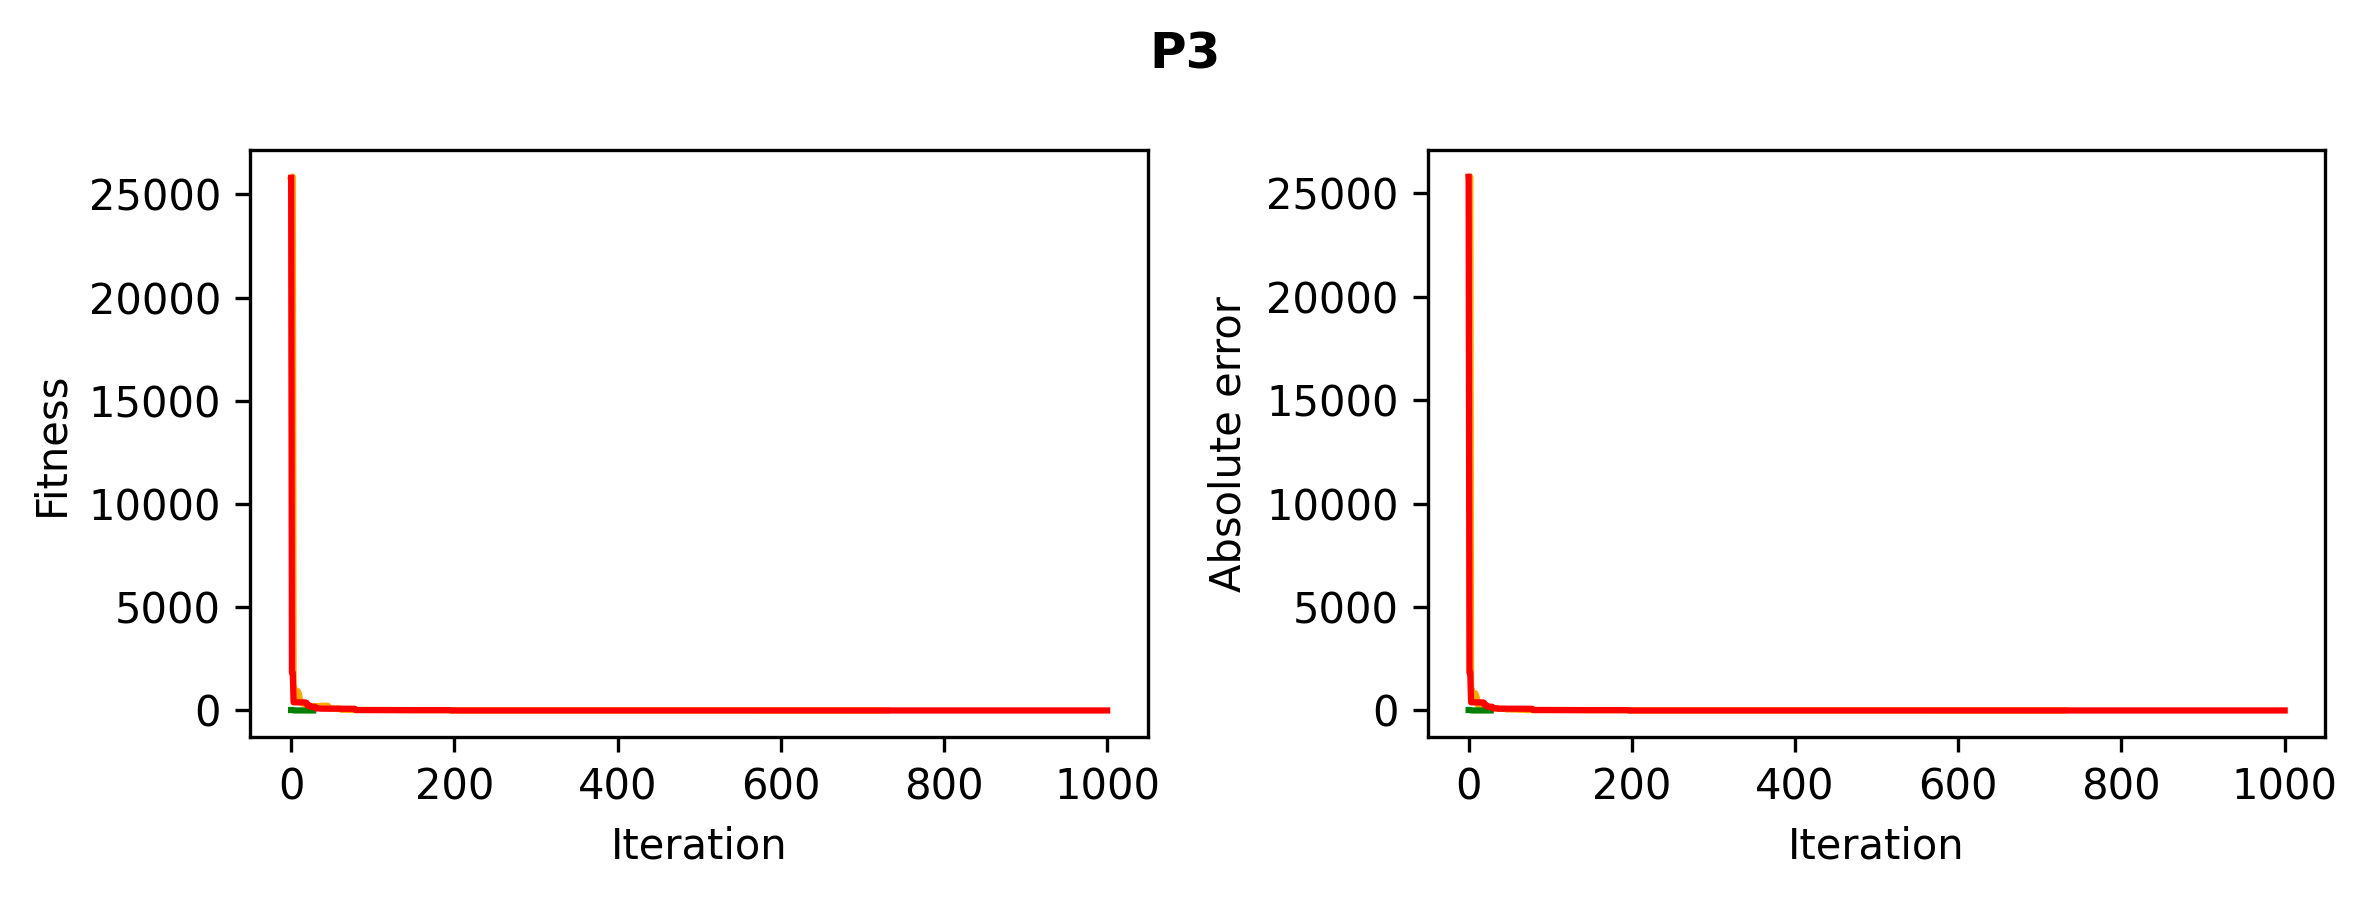

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax[0].plot(P3sa_F, color='orange', label='Simulated Annealing')
ax[0].plot(P3ga_F, color='green', label='Genetic Algorithm')
ax[0].plot(P3rs_F, color='red', label='Random Search')

ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')

ax[1].plot(np.abs(np.array(P3sa_V) - TARGET), color='orange', label='Simulated Annealing')
ax[1].plot(np.abs(np.array(P3ga_V) - TARGET), color='green', label='Genetic Algorithm')
ax[1].plot(np.abs(np.array(P3rs_V) - TARGET), color='red', label='Random Search')

ax[1].set_ylabel('Absolute error')
ax[1].set_xlabel('Iteration')

plt.suptitle('P3', fontweight='bold')
plt.tight_layout()
plt.show()

# Search for best parameters

## Best $T_0$ for Simulated Annealing

We will set a $T_0$ such that there is a probability of 0.9 of taking a worse solution at the start.

We calculate the mean $\Delta f$ by sampling several starts:

In [32]:
def estimate_T0(f, gen_neighbour, p_worse=0.9, nsamples=1000):
    dfs = np.zeros(int(nsamples))
    mean_df = 0
    samples = 0
    while samples < nsamples:
        n_initial = random.randint(8, len(NUMBERS)) # Number of numbers in the initial solution
        initial_op = Operation(
            numbers = random.sample(NUMBERS, k=n_initial),
            operations = random.choices(OPERATIONS, k=n_initial-1),
            order = random.sample(list(range(n_initial-1)), k=n_initial-1)
        )

        y = gen_neighbour(initial_op)
        f_y = f(y)
        f_initial = f(initial_op)
        if f_y > f_initial:
            df = f_y - f_initial
            dfs[samples] = df
            samples += 1

    T0 = - np.median(dfs) / math.log(p_worse)
    
    return T0, dfs

Estimate $T_0$ for problem P1:

In [33]:
T0, dfs = estimate_T0(f, get_neighbour, p_worse=0.9, nsamples=1e6)
T0, np.median(dfs)

(np.float64(474.3581476948339), np.float64(49.97861904761902))

We use the median instead of the mean in the estimation of T0, as our neighbour definition generates a few operations that evaluate to extremely high values, increasing the mean artificially. Thus, we are calculating $T_0$ such that:

$$
p = \exp\left(-\frac{\Delta f_{1/2}}{T_0}\right) = 0.9
$$

where $p$ is the probability of accepting the worse value which has a median difference in fitness compared to the initial solution ($\Delta f_{1/2}$). 

With this estimation of the temperature, 50% of the times a worse value is generated at the start of the algorithm, it will have a probability greater than 0.9 of being accepted.



We can see the disproportionately large mean due to a few high values in the following cell:

In [34]:
import pandas as pd
pd.Series(dfs[~np.isinf(dfs)]).describe()

count    9.981780e+05
mean     4.590553e+11
std      3.520956e+14
min      5.684342e-14
25%      3.799420e+00
50%      4.989322e+01
75%      1.282286e+03
max      3.270788e+17
dtype: float64

Initial temperature estimation for problem P2:

In [35]:
T0, dfs = estimate_T0(f2, get_neighbour, p_worse=0.9, nsamples=1e6)
T0

np.float64(949.1230776911775)

Initial temperature estimation for problem P3:

In [36]:
T0, dfs = estimate_T0(f, get_neighbour_nrpt, p_worse=0.9, nsamples=1e6)
T0

np.float64(474.56107905149526)

# Algorithm comparisons

In [61]:
import time
import pandas as pd

# Generic function to execute a function and measure the time it takes
def measure_execution_time(func, *args, **kwargs):
    start_time = time.time()
    results = func(*args, **kwargs) 
    end_time = time.time()
    execution_time = end_time - start_time
    return results, execution_time

# Run and retrieve results for each algorithm
def run_algorithms(f, check_valid, gen_neighbour, crossover, N=100, T0=500, max_iter=1000, tol=0.01):
    sa_results = []; ga_results = []; rs_results = []

    # Simulated Annealing
    for i in range(N):
        # Generate an initial solution for Simulated Annealing and RandomSearch
        n_initial = random.randint(8, len(NUMBERS))
        initial = Operation(
            numbers = random.sample(NUMBERS, k=n_initial),
            operations = random.choices(OPERATIONS, k=n_initial-1),
            order = random.sample(list(range(n_initial-1)), k=n_initial-1)
        )

        (sa_x, sa_f, sa_X, sa_V, sa_F, sa_Tv), sa_time = measure_execution_time(
            simulated_annealing, initial, f, check_valid, gen_neighbour, T0=T0, alpha=0.90, max_iterations=max_iter, tol=tol, log=False
        )
        sa_results.append({
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": sa_time,
            "Iteraciones": len(sa_F) - 1,
            "Mejor solución": sa_x,
            "Mejor fitness": sa_f,
            "Trayectoria": sa_F
        })

        # Genetic Algorithm
        (ga_x, ga_f, ga_X, ga_V, ga_F), ga_time = measure_execution_time(
            genetic_algorithm, f, check_valid, crossover, gen_neighbour, population_size=100, mutation_rate=0.1, max_generations=max_iter, tol=tol, log=False
        )
        ga_results.append({
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": ga_time,
            "Iteraciones": len(ga_F) - 1,
            "Mejor solución": ga_x,
            "Mejor fitness": ga_f,
            "Trayectoria": ga_F
        })

        # Random Search
        (rs_x, rs_f, rs_X, rs_V, rs_F), rs_time = measure_execution_time(
            random_search, initial, f, check_valid, gen_neighbour, max_iterations=max_iter, tol=tol, log=False
        )
        rs_results.append({
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": rs_time,
            "Iteraciones": len(rs_F) - 1,
            "Mejor solución": rs_x,
            "Mejor fitness": rs_f,
            "Trayectoria": rs_F
        })

    return pd.DataFrame(sa_results), pd.DataFrame(ga_results), pd.DataFrame(rs_results)

Number of runs for each algorithm:

In [17]:
N = 10

# Problem P1

Results for problem P1 (`f`, `check_valid`, `get_neighbour`, `crossover`):

In [62]:
P1sa_results, P1ga_results, P1rs_results = run_algorithms(f, check_valid, get_neighbour, crossover, N = N, T0 = 500)

In [72]:
P1sa_results['Algoritmo'] = 'RS'
P1ga_results['Algoritmo'] = 'AG'
P1rs_results['Algoritmo'] = 'BA'

P1df = pd.concat([P1sa_results, P1ga_results, P1rs_results]).reset_index()
P1df.to_csv('./P1results.csv', index=False)


In [69]:
P1df = pd.read_csv('P1results.csv')

In [ ]:
maxlen = max(map(len, P1sa_results['Trayectoria']))
padded = pd.concat([P1df['Algoritmo'], P1df['Trayectoria'].apply(lambda lst: np.pad(lst, (0, maxlen - len(lst)), mode='edge'))], axis=1)
means = padded.groupby('Algoritmo').mean()
sems = padded.groupby('Algoritmo').agg(lambda res: )

TypeError: setting an array element with a sequence.

In [119]:
P1ga_results['Trayectoria'].apply(lambda lst: np.pad(lst, (0, maxlen - len(lst)), mode='edge')).mean()

array([51.30231652, 51.30231652, 14.31303101, ...,  0.13980194,
        0.13980194,  0.13980194], shape=(1001,))

/tmp/ipykernel_335334/2361400196.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = P1df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,


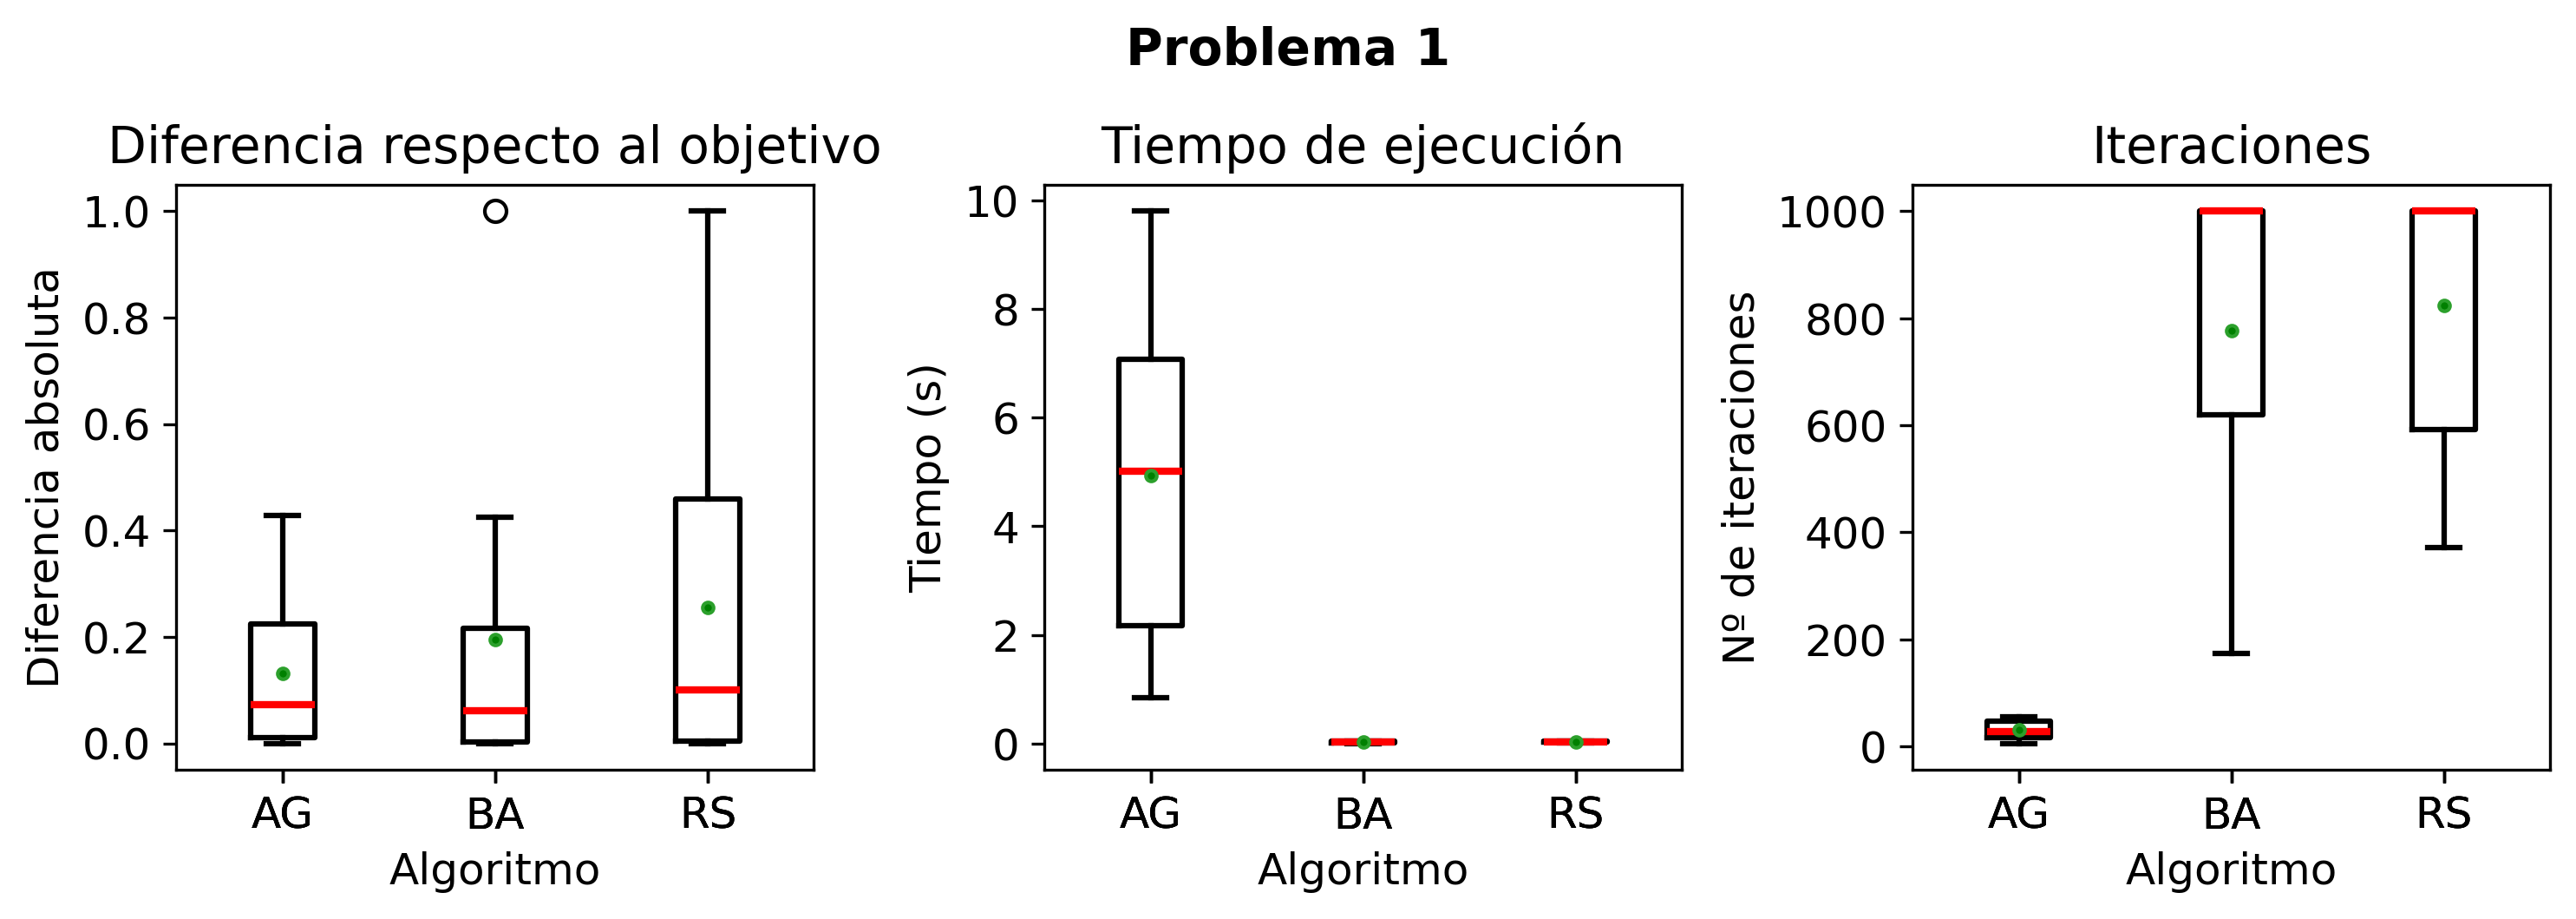

In [43]:
columns = ['Mejor fitness', 'Tiempo de ejecución (s)', 'Iteraciones']
title_size = 14
label_size = 12

fig = plt.figure(figsize=(10, 6), dpi=300)
axes = P1df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,
                    boxprops=dict(linewidth=1.5),
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(marker='o', markerfacecolor='green', markersize=3),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5))

axes['Mejor fitness'].set_title('Diferencia respecto al objetivo', fontsize=title_size)
axes['Mejor fitness'].set_ylabel('Diferencia absoluta', fontsize=label_size)
axes['Tiempo de ejecución (s)'].set_title('Tiempo de ejecución', fontsize=title_size)
axes['Tiempo de ejecución (s)'].set_ylabel('Tiempo (s)', fontsize=label_size)
axes['Iteraciones'].set_title('Iteraciones', fontsize=title_size)
axes['Iteraciones'].set_ylabel('Nº de iteraciones', fontsize=label_size)

for ax in axes.values:
    ax.set_xlabel('Algoritmo', fontsize=label_size)

plt.suptitle("Problema 1", fontweight='bold', fontsize=title_size)
plt.tight_layout()
plt.show()

Number of times each algorithm reached the global optimum (tol = 0.01):

In [44]:
P1df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01))

Algoritmo
AG    3
BA    4
RS    4
Name: Mejor fitness, dtype: int64

Best solutions found:

In [46]:
best_solutions = P1df.loc[P1df.groupby("Algoritmo")["Mejor fitness"].idxmin(), ["Algoritmo", "Mejor solución", "Mejor fitness"]]
pd.set_option('display.max_colwidth', None)
best_solutions

,Algoritmo,Mejor solución,Mejor fitness
12,AG,"[30, 23, 50, 25, 7, 60, 40, 40, 7, 3, 35, 12, 2, 15] ['*', '/', '/', '+', '+', '+', '+', '+', '/', '/', '*', '/', '-'] [3, 0, 2, 1, 4, 5, 8, 9, 11, 10, 7, 12, 6]",0.0
25,BA,"[12, 50, 35, 7, 7, 60, 3, 10, 30, 20, 15, 3, 3] ['*', '+', '*', '*', '/', '*', '*', '+', '/', '+', '+', '+'] [3, 4, 2, 5, 6, 1, 0, 7, 8, 9, 10, 11]",0.0
5,RS,"[7, 3, 2, 35, 12, 60, 60, 30, 2] ['*', '+', '*', '*', '/', '+', '+', '-'] [3, 2, 4, 1, 5, 0, 6, 7]",0.0


# Problem P2

Results for problem P2 (`f2`, `check_valid2`, `get_neighbour`, `crossover`):

In [47]:
P2sa_results, P2ga_results, P2rs_results = run_algorithms(f2, check_valid2, get_neighbour, crossover, N = N, T0 = 1000)

In [48]:
P2sa_results['Algoritmo'] = 'RS'
P2ga_results['Algoritmo'] = 'AG'
P2rs_results['Algoritmo'] = 'BA'

P2df = pd.concat([P2sa_results, P2ga_results, P2rs_results]).reset_index()
P2df.to_csv('P2results.csv', index=False)

In [49]:
P2df = pd.read_csv('P2results.csv')

/tmp/ipykernel_335334/92860814.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = P2df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,


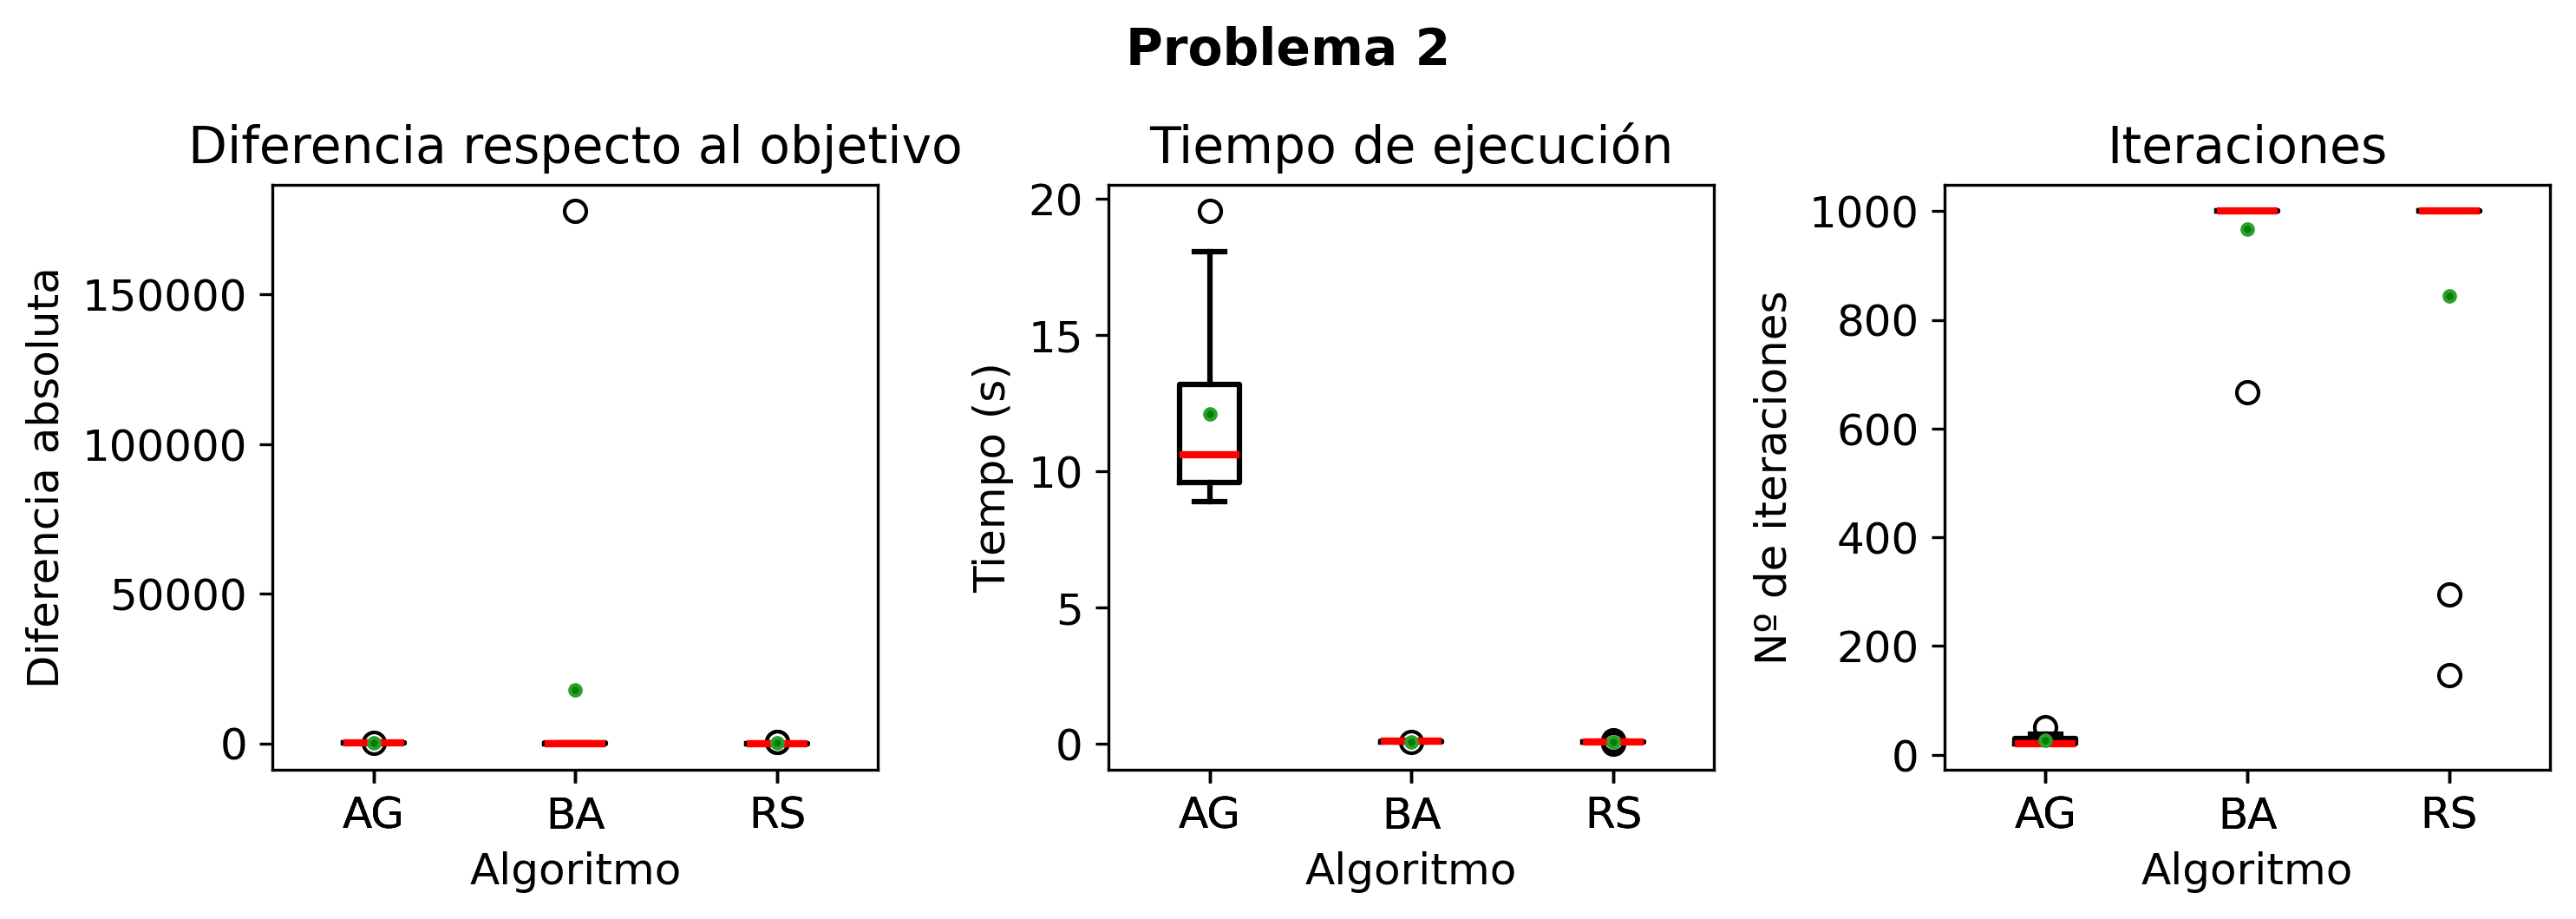

In [50]:
columns = ['Mejor fitness', 'Tiempo de ejecución (s)', 'Iteraciones']
title_size = 14
label_size = 12

fig = plt.figure(figsize=(10, 6), dpi=300)
axes = P2df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,
                    boxprops=dict(linewidth=1.5),
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(marker='o', markerfacecolor='green', markersize=3),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5))

axes['Mejor fitness'].set_title('Diferencia respecto al objetivo', fontsize=title_size)
axes['Mejor fitness'].set_ylabel('Diferencia absoluta', fontsize=label_size)
axes['Tiempo de ejecución (s)'].set_title('Tiempo de ejecución', fontsize=title_size)
axes['Tiempo de ejecución (s)'].set_ylabel('Tiempo (s)', fontsize=label_size)
axes['Iteraciones'].set_title('Iteraciones', fontsize=title_size)
axes['Iteraciones'].set_ylabel('Nº de iteraciones', fontsize=label_size)

for ax in axes.values:
    ax.set_xlabel('Algoritmo', fontsize=label_size)

plt.suptitle("Problema 2", fontweight='bold', fontsize=title_size)
plt.tight_layout()
plt.show()

Number of times each algorithm reached the global optimum (tol = 0.01):

In [51]:
P2df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01))

Algoritmo
AG    0
BA    1
RS    2
Name: Mejor fitness, dtype: int64

Best solutions found:

In [52]:
best_solutions = P2df.loc[P2df.groupby("Algoritmo")["Mejor fitness"].idxmin(), ["Algoritmo", "Mejor solución", "Mejor fitness"]]

best_solutions

,Algoritmo,Mejor solución,Mejor fitness
10,AG,"[3, 25, 60, 10, 40, 7, 2, 5, 50, 30, 23, 15] ['*', '+', '*', '-', '-', '+', '*', '*', '/', '-', '-'] [2, 3, 4, 0, 1, 9, 7, 10, 8, 6, 5]",1.5
24,BA,"[12, 3, 20, 15, 50, 40, 35, 23, 25] ['-', '*', '/', '+', '-', '*', '+', '-'] [4, 6, 5, 0, 1, 7, 2, 3]",0.0
0,RS,"[20, 15, 12, 10, 23, 25, 60, 2, 7] ['-', '*', '-', '-', '-', '+', '+', '+'] [3, 6, 5, 4, 2, 0, 1, 7]",0.0


# Problem P3

Results for problem P3 (`f`, `check_valid2`, `get_neighbour_nrpt`, `crossover_nrpt`):

In [60]:
P3sa_results, P3ga_results, P3rs_results = run_algorithms(f, check_valid2, get_neighbour_nrpt, crossover_nrpt, N = N, T0 = 500)

In [61]:
P3sa_results['Algoritmo'] = 'RS'
P3ga_results['Algoritmo'] = 'AG'
P3rs_results['Algoritmo'] = 'BA'

P3df = pd.concat([P3sa_results, P3ga_results, P3rs_results]).reset_index()
P3df.to_csv('./P3results.csv', index=False)


In [62]:
P3df = pd.read_csv('P3results.csv')

/tmp/ipykernel_335334/907560391.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = P3df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,


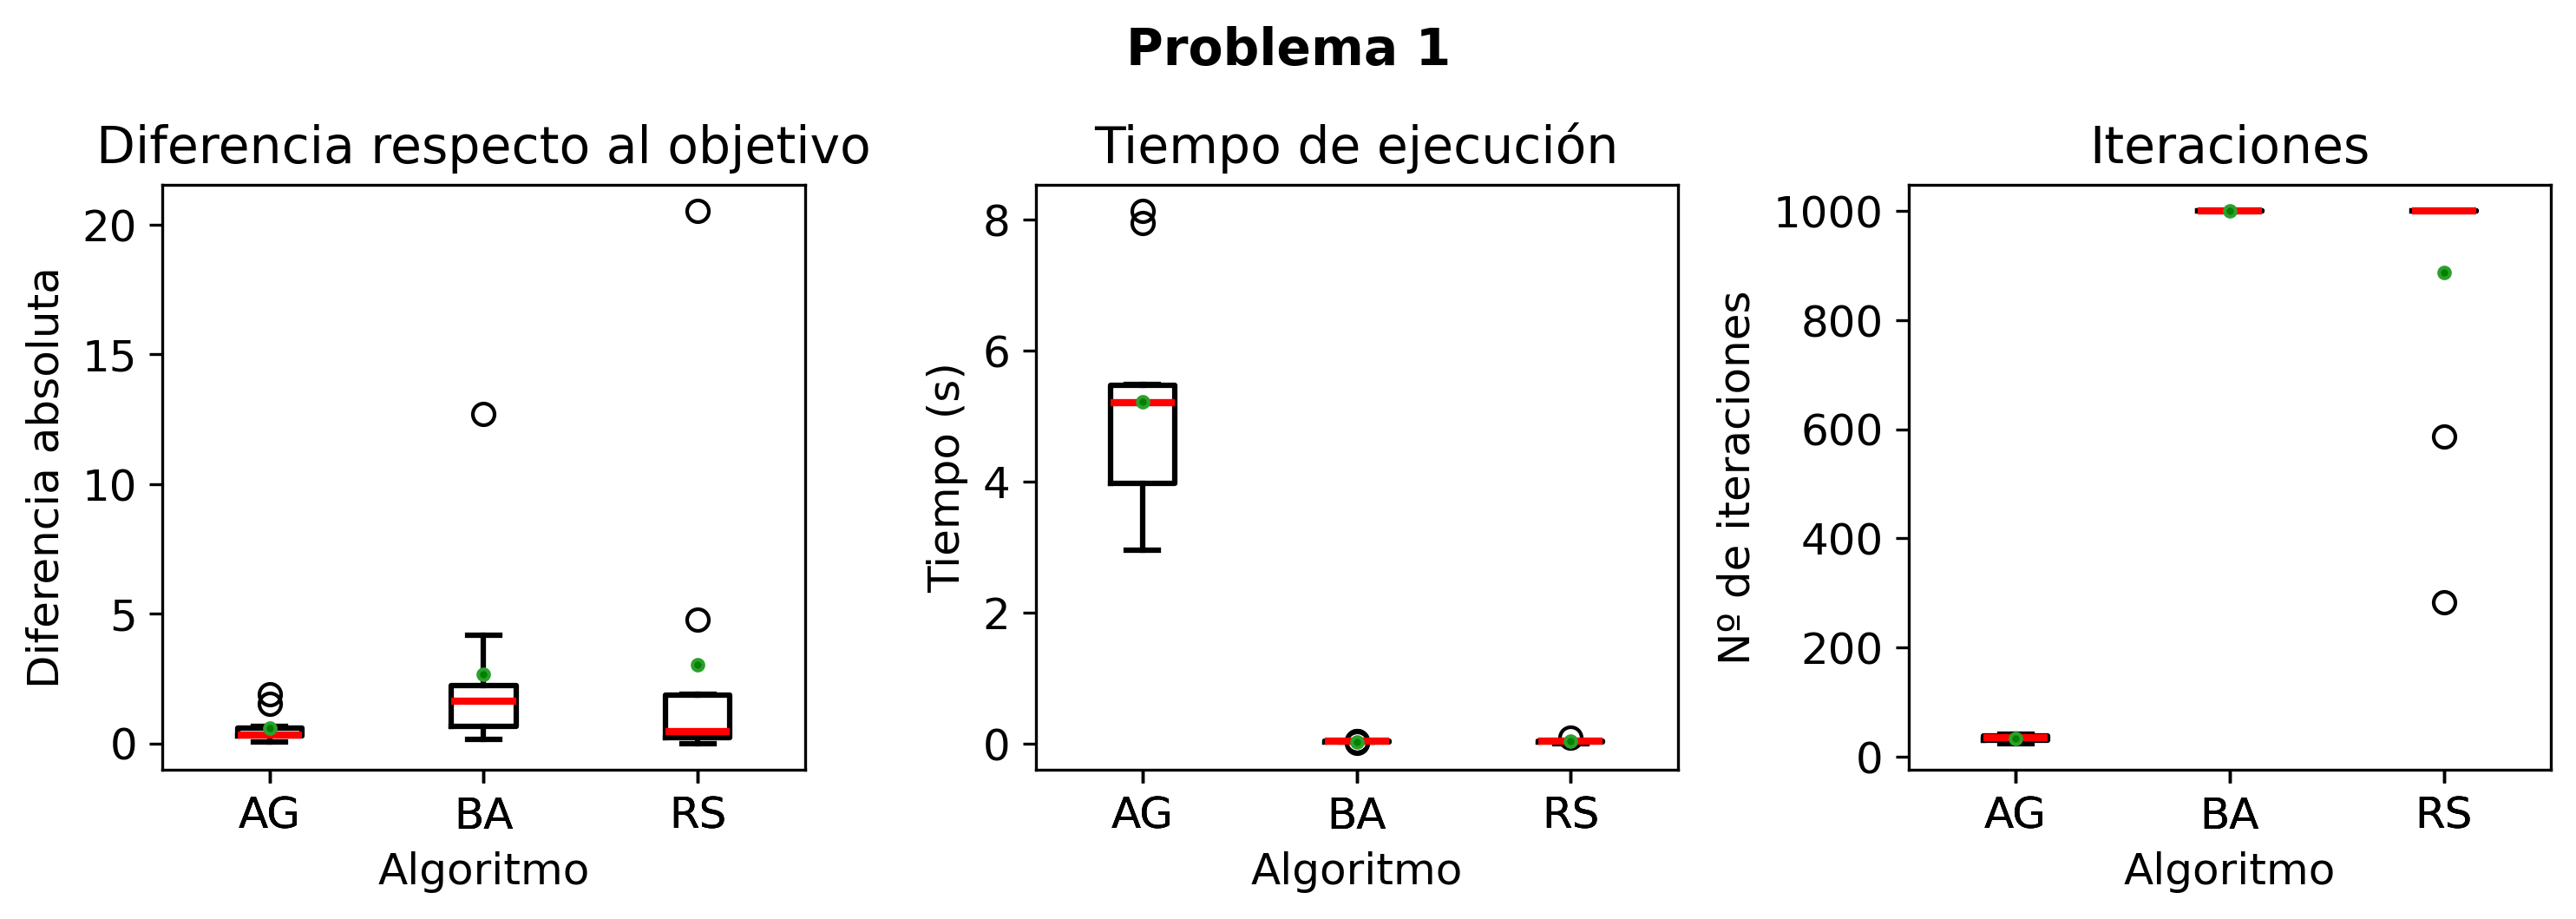

In [63]:
columns = ['Mejor fitness', 'Tiempo de ejecución (s)', 'Iteraciones']
title_size = 14
label_size = 12

fig = plt.figure(figsize=(10, 6), dpi=300)
axes = P3df.boxplot(columns, by='Algoritmo', ax=fig, layout=(2, 3), sharey=False, return_type='axes', showmeans=True, fontsize=label_size, grid=False,
                    boxprops=dict(linewidth=1.5),
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(marker='o', markerfacecolor='green', markersize=3),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5))

axes['Mejor fitness'].set_title('Diferencia respecto al objetivo', fontsize=title_size)
axes['Mejor fitness'].set_ylabel('Diferencia absoluta', fontsize=label_size)
axes['Tiempo de ejecución (s)'].set_title('Tiempo de ejecución', fontsize=title_size)
axes['Tiempo de ejecución (s)'].set_ylabel('Tiempo (s)', fontsize=label_size)
axes['Iteraciones'].set_title('Iteraciones', fontsize=title_size)
axes['Iteraciones'].set_ylabel('Nº de iteraciones', fontsize=label_size)

for ax in axes.values:
    ax.set_xlabel('Algoritmo', fontsize=label_size)

plt.suptitle("Problema 1", fontweight='bold', fontsize=title_size)
plt.tight_layout()
plt.show()

Number of times each algorithm reached the global optimum (tol = 0.01):

In [64]:
P3df.groupby('Algoritmo')['Mejor fitness'].agg(lambda x: np.sum(x < 0.01))

Algoritmo
AG    0
BA    0
RS    2
Name: Mejor fitness, dtype: int64

Best solutions found:

In [65]:
best_solutions = P3df.loc[P3df.groupby("Algoritmo")["Mejor fitness"].idxmin(), ["Algoritmo", "Mejor solución", "Mejor fitness"]]

best_solutions

,Algoritmo,Mejor solución,Mejor fitness
17,AG,"[7, 25, 3, 10, 20, 35, 60, 23, 12, 30, 15, 5, 50, 2] ['/', '-', '+', '-', '/', '*', '+', '+', '+', '+', '+', '*', '/'] [7, 3, 4, 1, 0, 2, 8, 10, 11, 12, 9, 5, 6]",0.051948
23,BA,"[35, 15, 25, 20, 60, 2, 23, 3, 7, 50, 40, 30, 12, 5] ['*', '-', '/', '-', '/', '+', '/', '-', '*', '-', '-', '+', '-'] [4, 9, 6, 3, 0, 2, 8, 7, 5, 1, 10, 11, 12]",0.166667
5,RS,"[25, 60, 15, 30, 12, 2, 5, 20, 7] ['+', '+', '*', '+', '+', '+', '+', '-'] [2, 4, 3, 5, 7, 6, 0, 1]",0.000000


# TEST

In [45]:
testdf = pd.DataFrame([[1, 2], [3, 4]], columns=('A', 'B'))
testdf['A'] = testdf['A'].apply(lambda x: x + 1)
testdf

,A,B
0,2,2
1,4,4
